# 気象衛星ひまわり

衛星データは，放射輝度等をセンサで測定しています。バイアス等の修正を行ったあと，物理量に変換するとともに，座標変換をして格子点に内挿し使いやすい形に変換して提供されています。データ処理の程度を[レベル](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/data-information-policy/data-levels)といいます。処理前のセンサの解像度そのままのデータをレベル0，補正や時空間の情報が付加されたものをレベル1，物理量に変換したものをレベル2，一様な時空間に内挿されたものをレベル3，モデルの出力や複数の測定を組み合わせたものをレベル4といいます。ここでは，千葉大学環境リモートセンシング研究センター（CEReS）から提供されているレベル3の気象衛星ひまわり8号のデータを使います。[リリースノート](http://www.cr.chiba-u.jp/databases/GEO/H8_9/FD/index_jp_V20190123.html)を参考に読み解いていきましょう。

[ひまわり](https://www.data.jma.go.jp/sat_info/himawari/role.html)8号は可視，近赤外，赤外の16バンド（波長帯）を観測しています。CEReSのレベル3赤外データは6,000×6,000点で水平解像度は約2
kmです。ファイルはFTPサーバから提供されています。Python標準ライブラリの`ftplib`を使うこともできますが，1行で済む`curl`コマンドを使うことにします。シェルのコマンドを呼び出すには，最初に`!`を付けます。

In [1]:
server = "ftp://hmwr829gr.cr.chiba-u.ac.jp/gridded/FD/V20190123"
yyyymm = "202107"
ddhhnn = "221200"
band = "tir"
ch = "01"
ext = "fld.geoss.bz2"
fname = f"{yyyymm}{ddhhnn}.{band}.{ch}.{ext}"
url = f"{server}/{yyyymm}/{band.upper()}/{fname}"
!curl -O $url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 27.0M    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 27.0M    1  517k    0     0   517k      0  0:00:53  0:00:01  0:00:52  324k
  4 27.0M    4 1314k    0     0   657k      0  0:00:42  0:00:02  0:00:40  509k
 11 27.0M   11 3319k    0     0  1106k      0  0:00:25  0:00:03  0:00:22  927k
 19 27.0M   19 5501k    0     0  1375k      0  0:00:20  0:00:04  0:00:16 1201k
 31 27.0M   31 8715k    0     0  1743k      0  0:00:15  0:00:05  0:00:10 1743k
 40 27.0M   40 11.0M    0     0  1886k      0  0:00:14  0:00:06  0:00:08 2153k
 48 27.0M   48 13.0M    0     0  1908k      0  0:00:14  0:00:07  0:00:07 2408k
 56 27.0M   56 15.3M    0     0  1960k      0  0:00:14  0:00:08  0:00:06 2472k
 67 27.0M   67 18.4M    0     0  2093k      0  0:00

データにはセンサが測定したカウント値（デジタル値）が格納されています。放射輝度への変換テーブルをダウンロードし展開します。

In [1]:
import numpy as np


cfname = "count2tbb_v102.tgz"
url = f"http://www.cr.chiba-u.jp/databases/GEO/H8_9/FD/{cfname}"
!curl -O $url
!tar zxvf $cfname
_, tbb = np.loadtxt(f"count2tbb_v102/{band}.{ch}", unpack=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1038k  100 1038k    0     0  11.1M      0 --:--:-- --:--:-- --:--:-- 11.1M
x ._count2tbb_v102
x count2tbb_v102/
x count2tbb_v102/tir.08
x count2tbb_v102/tir.01
x count2tbb_v102/tir.06
x count2tbb_v102/mktable.sh
x count2tbb_v102/tir.07
x count2tbb_v102/tir.09
x count2tbb_v102/._.DS_Store
x count2tbb_v102/.DS_Store
x count2tbb_v102/._main20.f90.patch
x count2tbb_v102/main20.f90.patch
x count2tbb_v102/grads05.ctl
x count2tbb_v102/grads10.ctl
x count2tbb_v102/._count2tbb10.c
x count2tbb_v102/count2tbb10.c
x count2tbb_v102/._main05.f90
x count2tbb_v102/main05.f90
x count2tbb_v102/._main10.f90
x count2tbb_v102/main10.f90
x count2tbb_v102/sir.01
x count2tbb_v102/vis.03
x count2tbb_v102/LUT_H08/
x count2tbb_v102/vis.02
x count2tbb_v102/ext.01
x count2tbb_v102/tir.05
x count2tbb_v102/._main05.f90.patch
x count2tbb_v102/main05.f90.patc

NameError: name 'band' is not defined

tarはファイルやディレクトリをまとめたアーカイブファイルを扱うコマンドです。ここではgzip圧縮を解凍するとともに，ディレクトリやファイルに展開しています。
`numpy.loadtxt()`メソッドを使って変換テーブルを読みます。最初の`_`は返り値を無視することを表しています。

座標系を定義します。

In [3]:
import numpy as np
 
lon_min, lon_max = 85, 205
lat_min, lat_max = -60, 60
resolution = 0.02
lon = np.arange(lon_min, lon_max, resolution)
lat = np.arange(lat_max, lat_min, -resolution)

データファイルを読んで等価黒体温度に変換します。

In [4]:
import bz2
 
n = 6000
with bz2.BZ2File(fname) as bz2file:
   dataDN = np.frombuffer(bz2file.read(), dtype=">u2").reshape(n, n)
   dataTBB = tbb[dataDN]

ファイルはbzip2圧縮されているので，標準ライブラリbz2を使って開きます。`read()`メソッドでバイナリデータをメモリに読み，`numpy.frombuffer()`メソッドで数値に変換しています。バイナリデータは，バイト数とバイトの並び順序（エンディアン）を指定する必要があります。`dtype=">u2"`で型を指定していますが，`>`はビッグエンディアン，`u`は符号なし，`2`はバイト数を表しています。なお，現在のほとんどの計算機に使われているプロセッサのエンディアンはリトルエンディアンですが，ビッグエンディアンはかつての大型計算機で多く使われていました。ビッグエンディアンは，ネットワークのプロトコルで用いられているため，ネットワークオーダーと呼ばれることもあります。

まず，ヒストグラムを描いてみましょう。

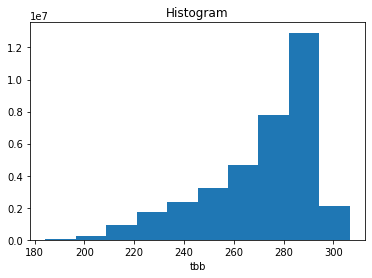

In [5]:
import matplotlib.pyplot as plt
import xarray as xr

xr_tbb = xr.DataArray(np.float32(dataTBB), name="tbb",
                      coords = {
                          'lat':('lat', lat, {'units': 'degrees_north'}),
                          'lon':('lon', lon, {'units': 'degrees_east'})},
                      dims = ['lat', 'lon'])
xr_tbb.plot.hist()
plt.show()

$T_{\mathrm{BB}}$の範囲は$200$から$300$で良さそうです。

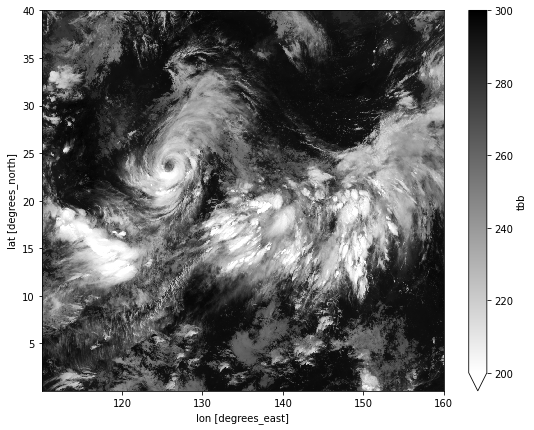

In [6]:
xr_tbb.loc[40:0, 110:160].plot.imshow(vmin=200, vmax=300,
                  interpolation="None", cmap="gray_r", figsize=[9,7])
plt.show()